# Qboost: Binary Classification with Quantum Computer

The D-Wave quantum computer has been widely studied as a discrete optimization engine that accepts any problem formulated as quadratic unconstrained  binary  optimization  (QUBO). In 2008, Google and D-Wave published a paper, [Training a Binary Classifier with the Quantum Adiabatic Algorithm](https://arxiv.org/pdf/0811.0416.pdf), which describes how the `Qboost` ensemble method makes binary classification amenable to quantum computing: the problem is formulated as a thresholded linear superposition of a set of weak classifiers and the D-Wave quantum computer is  used to optimize the weights in a learning process that strives to minimize the training error and number of weak classifiers.

This notebook demonstrates and explains how the Qboost algorithm can be used to solve a binary classification problem. 

## A Few Words on Ensemble Methods

Ensemble methods build a strong classifier (an improved model) by combining weak classifiers with the goal of:

* decreasing variance (bagging)
* decreasing bias (boosting)
* improving prediction (voting)

![Boosting Algorithm](images/boosting.jpg)

### Bagging, Boosting, and Voting

The ensemble method produces new training data sets by random sampling with replacement from the original set. In _bagging_, any element has the same probability to appear in a new dataset; in _boosting_, data elements are weighted before they are collected in the new dataset. Another distinction is that bagging is parallelizable but boosting has to be executed sequentially. You can learn more about the differences between these methods here: https://quantdare.com/what-is-the-difference-between-bagging-and-boosting/.

Voting operates on labels only. Unlike boosting, the aggeragated classification performance is not used to further polish each weak classifier. Voting has two typical requirements of its collection of  weak classifiers: that there be __many__ and that they be __diverse__.  

## Weak and Strong Classifiers
For this reference example we chose the following four classifiers:
    1. Adaboost
    2. Decision Trees
    3. Random Forest
    4. Qboost
Note that you can replace any of these with any commonly used classification model. Also, an ensemble method can use a strong classifier instead of a weak one, and in this example we embed the Qboost classifier itself, __QboostPlus__ in the following code, with the first three.  

### Adaboost
Adaboost combines a number of $N$ weak classifiers into a strong one as
$$C(x) = sign\left(\sum_i^N w_i c_i(x)\right),$$
with $c_i(x) \in [-1, +1]$ being the $i$-th weak classifier:

$$c_i(x) = sign(w'*x + b)$$

The loss function of Adaboost is defined as
$$
L = \sum_{n=1}^N \exp\left\{ - y_n \sum_{s=1}^S w_sc_k(x_n)\right\}.
$$

The strong classifier $C(\cdot)$ is constructed in an iterative fashion. In each iteration, one weak classifier
is selected and re-learned to minimize the weighted error function. Its weight is adjusted and renormalized to make sure the sum of all weights equals 1. 

The final classification model will be decided by a weighted “vote” of all the weak classifiers. 

### Decision Trees
A decision tree builds on a tree structure with non-leaf nodes encoding decision rules and leaf nodes encoding labels. You construct a decision tree by optimizing either entropic or information-theoretic metrics. Controlling the depth of a decision tree indirectly decides the sub-dimension of the dataset. 

Decision trees are often chosen as the weak classifiers in Adaboost because they are both simple to construct and fast to do inference. The `scikit-learn` package implements its Adaboost method with decision trees of depth 1, also known as _tree stumps_. This reference examples demonstrates an alternative implementation of boosting with a number of deeper decision trees.
### Random Forest 
Random forest is an ensemble method that typically implements bagging on a set of decision trees. By introducing randomness in the selection of an optimized feature in the training of the underlying decision trees, the ensemble diversifies the weightings of its collection of weak classifiers, generally resulting in an improved model.    

### Qboost
To make use of the optimization power of D-Wave quantum annealer, we needs to formulate our objective function as a quadratic unconstrained binary optimization (QUBO) problem. Therefore, we replace the exponential loss as in Adaboost with the following quadratic loss
$$
w* = \arg\min_w\left(\sum_s \left(\frac{1}{N}\sum_n^N w_nc_n(x_s) - y_s\right)^2\right) + \lambda ||w||_0,
$$
where the regularization term is added to enable controlling of weight sparsity.

Note in Qboost, the weight vector is binary.



## Training and Comparing Performance
Now we define functions used in the following experiemnts to train our selected classifiers and provide metrics for comparing performance.

First, copy your API token.

In [2]:
# Fill in your API token:
sapi_token = 'CDL8-9be73dd6404b740dffde6f9df7947c50844e89de'

Now let us import the required packages.

In [5]:
# import necessary packages
from sklearn import preprocessing, metrics
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.datasets.mldata import fetch_mldata
from sklearn.datasets import load_breast_cancer
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

from qboost import WeakClassifiers, QBoostClassifier, QboostPlus

Next, let us define the `metric` and `train_model` functions:

In [6]:
from dwave_sapi2.remote import RemoteConnection

url = 'https://cloud.dwavesys.com/sapi'
token = sapi_token
conn = RemoteConnection(url, token)
print conn.solver_names()

['DW_2000Q_VFYC_2', 'DW_2000Q_2', 'c4-sw_optimize', 'c4-sw_sample']


In [7]:
# Define the functions required in this example
def metric(y, y_pred):
    """
    :param y: true label
    :param y_pred: predicted label
    :return: metric score
    """

    return metrics.accuracy_score(y, y_pred)


def train_model(X_train, y_train, X_test, y_test, lmd):
    """
    :param X_train: training data
    :param y_train: training label
    :param X_test: testing data
    :param y_test: testing label
    :param lmd: lambda used in regularization
    :return:
    """

    # define parameters used in this function
    NUM_READS = 1000
    NUM_WEAK_CLASSIFIERS = 30
    TREE_DEPTH = 2
    DW_PARAMS = {'num_reads': NUM_READS,
                 'auto_scale': True,
                 'num_spin_reversal_transforms': 10,
                 'postprocess': 'optimization',
                 }

    # define sampler
    dwave_sampler = DWaveSampler(token=sapi_token)
    emb_sampler = EmbeddingComposite(dwave_sampler)

    N_train = len(X_train)
    N_test = len(X_test)
    print("\n======================================")
    print("Train size: %d, Test size: %d" %(N_train, N_test))
    print('Num weak classifiers:', NUM_WEAK_CLASSIFIERS)

    # Preprocessing data
    imputer = preprocessing.Imputer()
    scaler = preprocessing.StandardScaler()
    normalizer = preprocessing.Normalizer()

    X_train = scaler.fit_transform(X_train)
    X_train = normalizer.fit_transform(X_train)

    X_test = scaler.fit_transform(X_test)
    X_test = normalizer.fit_transform(X_test)

    ## Adaboost
    print('\nAdaboost')
    clf1 = AdaBoostClassifier(n_estimators=NUM_WEAK_CLASSIFIERS)
    clf1.fit(X_train, y_train)
    y_train1 = clf1.predict(X_train)
    y_test1 = clf1.predict(X_test)
#     print(clf1.estimator_weights_)
    print('accu (train): %5.2f'%(metric(y_train, y_train1)))
    print('accu (test): %5.2f'%(metric(y_test, y_test1)))

    # Ensembles of Decision Tree
    print('\nDecision tree')
    clf2 = WeakClassifiers(n_estimators=NUM_WEAK_CLASSIFIERS, max_depth=TREE_DEPTH)
    clf2.fit(X_train, y_train)
    y_train2 = clf2.predict(X_train)
    y_test2 = clf2.predict(X_test)
#     print(clf2.estimator_weights)
    print('accu (train): %5.2f' % (metric(y_train, y_train2)))
    print('accu (test): %5.2f' % (metric(y_test, y_test2)))
    
    # Random forest
    print('\nRandom Forest')
    clf3 = RandomForestClassifier(max_depth=TREE_DEPTH, n_estimators=NUM_WEAK_CLASSIFIERS)
    clf3.fit(X_train, y_train)
    y_train3 = clf3.predict(X_train)
    y_test3 = clf3.predict(X_test)
    print('accu (train): %5.2f' % (metric(y_train, y_train3)))
    print('accu (test): %5.2f' % (metric(y_test, y_test3)))

    # Qboost
    print('\nQBoost')
    clf4 = QBoostClassifier(n_estimators=NUM_WEAK_CLASSIFIERS, max_depth=TREE_DEPTH)
    clf4.fit(X_train, y_train, emb_sampler, lmd=lmd, **DW_PARAMS)
    y_train4 = clf4.predict(X_train)
    y_test4 = clf4.predict(X_test)
    print(clf4.estimator_weights)
    print('accu (train): %5.2f' % (metric(y_train, y_train4)))
    print('accu (test): %5.2f' % (metric(y_test, y_test4)))

    # QboostPlus
    print('\nQBoostPlus')
    clf5 = QboostPlus([clf1, clf2, clf3, clf4])
    clf5.fit(X_train, y_train, emb_sampler, lmd=lmd, **DW_PARAMS)
    y_train5 = clf5.predict(X_train)
    y_test5 = clf5.predict(X_test)
    print(clf5.estimator_weights)
    print('accu (train): %5.2f' % (metric(y_train, y_train5)))
    print('accu (test): %5.2f' % (metric(y_test, y_test5)))

    print("===========================================================================")
    print("Method \t Adaboost \t DecisionTree \t RandomForest \t Qboost \t Qboost+")
    print("Train\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f"% (metric(y_train, y_train1),
                                                                         metric(y_train, y_train2),
                                                                         metric(y_train, y_train3),
                                                                         metric(y_train, y_train4),
                                                                         metric(y_train, y_train5),
                                                                        ))
    print("Test\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f \t\t %5.2f"% (metric(y_test, y_test1),
                                                                       metric(y_test, y_test2),
                                                                       metric(y_test, y_test3),
                                                                       metric(y_test, y_test4),
                                                                       metric(y_test, y_test5)))
    print("===========================================================================")
    
    return [clf1, clf2, clf3, clf4, clf5]

## Experiments
Now we're ready to run some experiments.
First, import the required packages. 

In [8]:
import numpy as np
#import os
import matplotlib.pyplot as plt


### Experiment 1: Binary Classfication on the MNIST Dataset 
This example transforms the MNIST dataset (handwritten digits) into a binary classification problem. We assume all digits that are smaller than 5 are labelled as -1 and the rest digits are labelled as +1.

First, let us load the MINIST dataset:

In [1]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[0:10000]
y_train = y_train[0:10000]

Using TensorFlow backend.


11501568/11490434 [==============================] - 2s 0us/step


In [9]:
y_train2 = 2*(y_train >4) - 1
print((y_train >4))

[ True False False ...  True  True  True]


In [12]:
mnist = fetch_mldata('MNIST original')

idx_01 = np.where(mnist.target <= 9)[0]
np.random.shuffle(idx_01)
idx_01 = idx_01[:15000]
idx_train = idx_01[:2*len(idx_01)//3]
idx_test = idx_01[2*len(idx_01)//3:]

X_train = mnist.data[idx_train]
X_test = mnist.data[idx_test]

y_train = 2*(mnist.target[idx_train] >4) - 1
y_test = 2*(mnist.target[idx_test] >4) - 1

print("Training data size: (%d, %d)" %(X_train.shape))
print("Testing data size: (%d, %d)" %(X_test.shape))

error: [Errno 54] Connection reset by peer

Let us visualize the digits: digits with class $+1$ are shown as images with a black background while digits with class $-1$  as images with a white background.

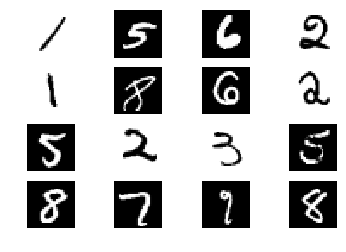

In [9]:
for i in range(16):
    if y_train[i] == 1:
        COLORMAP = 'gray'
    else:
        COLORMAP = 'gray_r'
    plt.subplot(4,4, i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap=COLORMAP)
    plt.axis('off')

Now train the model and compare the results of the selected classifiers.

In [10]:
# start training the model
clfs = train_model(X_train, y_train, X_test, y_test, 1.0)


Train size: 10000, Test size: 5000
('Num weak classifiers:', 30)


/opt/conda/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)



Adaboost
accu (train):  0.84
accu (test):  0.83

Decision tree
accu (train):  0.87
accu (test):  0.86

Random Forest
accu (train):  0.77
accu (test):  0.77

QBoost
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
accu (train):  0.87
accu (test):  0.86

QBoostPlus
[1 1 1 1]
accu (train):  0.86
accu (test):  0.86
Method 	 Adaboost 	 DecisionTree 	 RandomForest 	 Qboost 	 Qboost+
Train	  0.84 		  0.87 		  0.77 		  0.87 		  0.86
Test	  0.83 		  0.86 		  0.77 		  0.86 		  0.86


In [11]:
# TODO: for this cell, Graphviz executables must be on systems PATH 
# You can optionally visualize the decision trees by uncommenting the following code
# import graphviz
# from sklearn import tree
# clf = clfs[0]
# graph = graphviz.Source(tree.export_graphviz(clf.estimators_[0], out_file=None))
# graph.render(None, view=True)

### Experiment 2: Wisconsin Breast Cancer

This example classifies tumors in scikit-learn's Wisconsis breast cancer dataset as either malignant or benign (binary classification).

First, let us load the dataset.

In [12]:
wisc = load_breast_cancer()

idx = np.arange(len(wisc.target))
np.random.shuffle(idx)

# train on a random 2/3 and test on the remaining 1/3
idx_train = idx[:2*len(idx)//3]
idx_test = idx[2*len(idx)//3:]

X_train = wisc.data[idx_train]
X_test = wisc.data[idx_test]

y_train = 2 * wisc.target[idx_train] - 1  # binary -> spin
y_test = 2 * wisc.target[idx_test] - 1

Now train the model and compare the results of the selected classifiers.

In [13]:
# train the model
clfs = train_model(X_train, y_train, X_test, y_test, 1.0)


Train size: 379, Test size: 190
('Num weak classifiers:', 30)

Adaboost
accu (train):  1.00
accu (test):  0.96

Decision tree
accu (train):  1.00
accu (test):  0.98

Random Forest
accu (train):  0.96
accu (test):  0.95

QBoost
[1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1]
accu (train):  1.00
accu (test):  0.97

QBoostPlus
[1 1 1 1]
accu (train):  1.00
accu (test):  0.97
Method 	 Adaboost 	 DecisionTree 	 RandomForest 	 Qboost 	 Qboost+
Train	  1.00 		  1.00 		  0.96 		  1.00 		  1.00
Test	  0.96 		  0.98 		  0.95 		  0.97 		  0.97
